In [25]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import scipy.signal
import torch
import torch.nn as nn
import heapq
from sklearn import preprocessing 

In [26]:
#inisialize
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("cpu")

print(f'Devices: {device}')

Devices: cpu


In [27]:
#read file and load models path
h5path = '/Users/mclinwong/GitHub/CodesReproduction/DCN-DOA/Data/h5/'
pthpath = '/Users/mclinwong/GitHub/CodesReproduction/DCN-DOA/Data/pth/'
#read mat file
matpath = '/Users/mclinwong/GitHub/CodesReproduction/DCN-DOA/Data/matlib/'
figurepath = '/Users/mclinwong/GitHub/CodesReproduction/DCN-DOA/ReproducedCodes/Figures/'
read_temp=scipy.io.loadmat(matpath + 'data2_testall.mat')
S_est=read_temp['S_est']
S_est = S_est.transpose(0, 2, 1)
[r2, K, I] = np.shape(S_est)
S_abs = np.zeros((r2, I*2))
for i in range(r2):
    for j in range(I):
        S_abs[i, j] = S_est[i, 0, j]
        S_abs[i, I+j] = S_est[i, 1, j]    

S_label=read_temp['S_label']
R_est=read_temp['R_est']
DOA_train=read_temp['DOA_train']
theta=read_temp['theta']
gamma=read_temp['gamma']
gamma_R=read_temp['gamma_R']
S_label1 = np.expand_dims(S_label, 2)
normalizer = preprocessing.Normalizer().fit(R_est)

[r2,c]=np.shape(R_est)
[r2,I]=np.shape(S_label)
print(f'r2: {r2}, I: {I}, c: {c}')
print(f'S_est: {S_est.shape}, S_abs: {S_abs.shape} \nS_label: {S_label.shape},\nS_label1: {S_label1.shape} ,\nR_est: {R_est.shape}')


DOA = np.arange(I)-60
L = 120

r2: 321, I: 120, c: 56
S_est: (321, 2, 120), S_abs: (321, 240) 
S_label: (321, 120),
S_label1: (321, 120, 1) ,
R_est: (321, 56)


In [28]:
class CNN(nn.Module):
    def __init__(self,activ):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv1d(2,12,kernel_size=25, padding=12), nn.BatchNorm1d(12), activ())
        self.conv2 = nn.Sequential(nn.Conv1d(12,6,kernel_size=15, padding=7),  nn.BatchNorm1d(6), activ())
        self.conv3 = nn.Sequential(nn.Conv1d(6,3,kernel_size=5, padding=2), nn.BatchNorm1d(3), activ())
        self.conv4 = nn.Sequential(nn.Conv1d(3,1,kernel_size=3, padding=1),nn.BatchNorm1d(1), activ())
    
    def forward(self, x):  
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
       
        return out
cnnrelu = torch.load(pthpath + 'cnnrelu.pth')
cnntanh = torch.load(pthpath + 'cnntanh.pth')
cnnsigmoid = torch.load(pthpath + 'cnnsigmoid.pth')


In [29]:
# Shape of Conv1D: (batch_size, channels, seq_len)
# length_out = (length_in - kernel_size + 2 * padding) / stride + 1
class CNN_nobatchnorm(nn.Module):
    def __init__(self,activ):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv1d(2,12,kernel_size=25, padding=12), activ())
        self.conv2 = nn.Sequential(nn.Conv1d(12,6,kernel_size=15, padding=7), activ())
        self.conv3 = nn.Sequential(nn.Conv1d(6,3,kernel_size=5, padding=2), activ())
        self.conv4 = nn.Sequential(nn.Conv1d(3,1,kernel_size=3, padding=1), activ())
    
    def forward(self, x):  
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
       
        return out

cnnrelu_nobatchnorm = torch.load(pthpath + 'cnnrelu_nobatchnorm.pth')
cnntanh_nobatchnorm = torch.load(pthpath + 'cnntanh_nobatchnorm.pth')
cnnsigmoid_nobatchnorm = torch.load(pthpath + 'cnnsigmoid_nobatchnorm.pth')

In [30]:
class DNN(nn.Module):
    def __init__(self, activa):
        super(DNN, self).__init__()
        self.fc1 = nn.Sequential(nn.Linear(2*I, int(2*I/3)), nn.BatchNorm1d(int(2*I/3)), activa())
        self.fc2 = nn.Sequential(nn.Linear(int(2*I/3), int(4*I/9)), nn.BatchNorm1d(int(4*I/9)), activa())
        self.fc3 = nn.Sequential(nn.Linear(int(4*I/9), int(2*I/3)), nn.BatchNorm1d(int(2*I/3)), activa())
        self.fc4 = nn.Sequential(nn.Linear(int(2*I/3), I), nn.BatchNorm1d(I), activa())
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.fc4(out)
        return out
dnnrelu = torch.load(pthpath + 'dnnrelu.pth')
dnntanh = torch.load(pthpath + 'dnntanh.pth')
dnnsigmoid = torch.load(pthpath + 'dnnsigmoid.pth')

In [31]:
class DNN_nobatchnorm(nn.Module):
    def __init__(self, activa):
        super(DNN, self).__init__()
        self.fc1 = nn.Sequential(nn.Linear(2*L, int(2*L/3)), activa())
        self.fc2 = nn.Sequential(nn.Linear(int(2*L/3), int(4*L/9)), activa())
        self.fc3 = nn.Sequential(nn.Linear(int(4*L/9), int(2*L/3)), activa())
        self.fc4 = nn.Sequential(nn.Linear(int(2*L/3), L), activa())
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.fc4(out)
        return out
    
dnnrelu_nobatchnorm = torch.load(pthpath + 'dnnrelu_nobatchnorm.pth')
dnntanh_nobatchnorm = torch.load(pthpath + 'dnntanh_nobatchnorm.pth')
dnnsigmoid_nobatchnorm = torch.load(pthpath + 'dnnsigmoid_nobatchnorm.pth')

In [32]:
def Test(model, inputx, flag=1):
    model = model.to(device)
    model.eval()
    ls = []
    for i in range(r2):
        with torch.no_grad():
            if flag == 0:
                x = np.zeros((K, I))
                x[:, :] = inputx[i, :, :]
                #atttntion: the input of the model should be a tensor which is in the shape of (batch_size, channel, length)
                x = torch.from_numpy(x.reshape(1, K, I)).float().to('cpu')
            elif flag == 1:
                x = np.zeros(K*I)
                x[:] = inputx[i, :]
                x = torch.from_numpy(x.reshape(1, -1)).float().to('cpu')
            x = x.to(device)
            # print(np.shape(x))
            y = model(x)
            y = y.cpu().numpy()
            ls.append(y)
    predict = np.array(ls)
    return np.squeeze(predict)

In [33]:
def DOAPredict(predict, height = 0.1, nodetect = 0):
    peak = np.zeros((K, r2))
    for i in range(r2):
        li = predict[i,:]
        peaks_st = np.zeros((K))
        peaks_st = peaks_st + nodetect
        peaks,_ = scipy.signal.find_peaks(li, height=height)
        maxamp = heapq.nlargest(K, li[peaks])
        rank = np.zeros(np.shape(maxamp)[0])
        for s in range(np.shape(maxamp)[0]):
            rank[s] = np.where(li==maxamp[s])[0].item()
        
        if len(peaks) == K:
            peaks_st = peaks
        elif len(peaks) == 0:
            peaks_st = peaks_st
        elif len(peaks) < K:
            for t in range(len(peaks)):
                peaks_st[t] = peaks[t]
        elif len(peaks) > K:
            for j in range(K):
                peaks_st[j] = rank[j]

        peak[:,i] = sorted(peaks_st, reverse=True)

    return peak-60

In [34]:
predict_cnntanh = Test(cnntanh, S_est, 0)
doa_cnntanh = DOAPredict(predict_cnntanh)
predict_cnntanh_nobatchnorm = Test(cnntanh_nobatchnorm, S_est, 0)
doa_cnntanh_nobatchnorm = DOAPredict(predict_cnntanh_nobatchnorm)
predict_cnnrelu = Test(cnnrelu, S_est, 0)
doa_cnnrelu = DOAPredict(predict_cnnrelu)
predict_cnnrelu_nobatchnorm = Test(cnnrelu_nobatchnorm, S_est, 0)
doa_cnnrelu_nobatchnorm = DOAPredict(predict_cnnrelu_nobatchnorm)
predict_cnnsigmoid = Test(cnnsigmoid, S_est, 0)
doa_cnnsigmoid = DOAPredict(predict_cnnsigmoid)
predict_cnnsigmoid_nobatchnorm = Test(cnnsigmoid_nobatchnorm, S_est, 0)
doa_cnnsigmoid_nobatchnorm = DOAPredict(predict_cnnsigmoid_nobatchnorm)

predict_dnntanh = Test(dnntanh, S_abs, 1)
doa_dnntanh = DOAPredict(predict_dnntanh)
predict_dnntanh_nobatchnorm = Test(dnntanh_nobatchnorm, S_abs, 1)
doa_dnntanh_nobatchnorm = DOAPredict(predict_dnntanh_nobatchnorm)
predict_dnnrelu = Test(dnnrelu, S_abs, 1)
doa_dnnrelu = DOAPredict(predict_dnnrelu)
predict_dnnrelu_nobatchnorm = Test(dnnrelu_nobatchnorm, S_abs, 1)
doa_dnnrelu_nobatchnorm = DOAPredict(predict_dnnrelu_nobatchnorm)
predict_dnnsigmoid = Test(dnnsigmoid, S_abs, 1)
doa_dnnsigmoid = DOAPredict(predict_dnnsigmoid)
predict_dnnsigmoid_nobatchnorm = Test(dnnsigmoid_nobatchnorm, S_abs, 1)
doa_dnnsigmoid_nobatchnorm = DOAPredict(predict_dnnsigmoid_nobatchnorm)

doa_sbl = DOAPredict(gamma)
doa_sblr = DOAPredict(gamma_R)

In [35]:
def plotsampleindex(predict, name):
    with plt.style.context(['science']):
        plt.rcParams['figure.dpi'] = 300
        plt.rcParams['savefig.dpi'] = 300
        plt.ylim(-70,70)
        plt.plot(DOA_train.T)
        plt.plot(predict.T,'.')
        plt.title(name)
        plt.xlabel('Train Samples')
        plt.ylabel('DOA(°)')
        plt.savefig(figurepath + 'SampleIndex/' + name + '.pdf')
        plt.show()

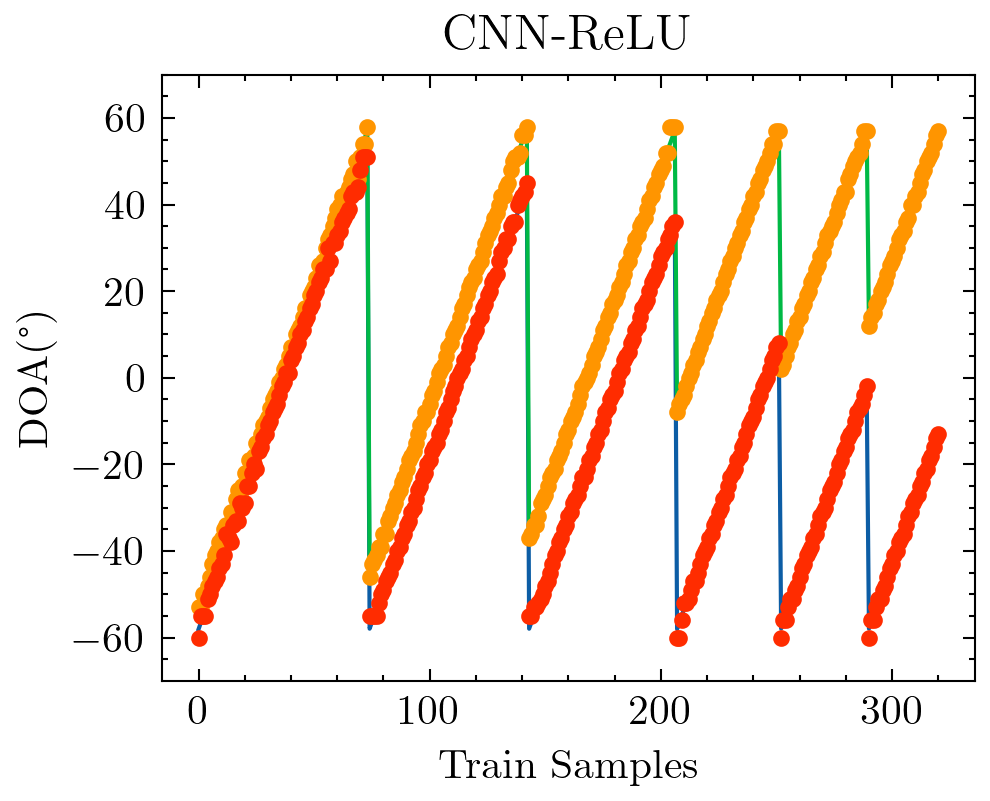

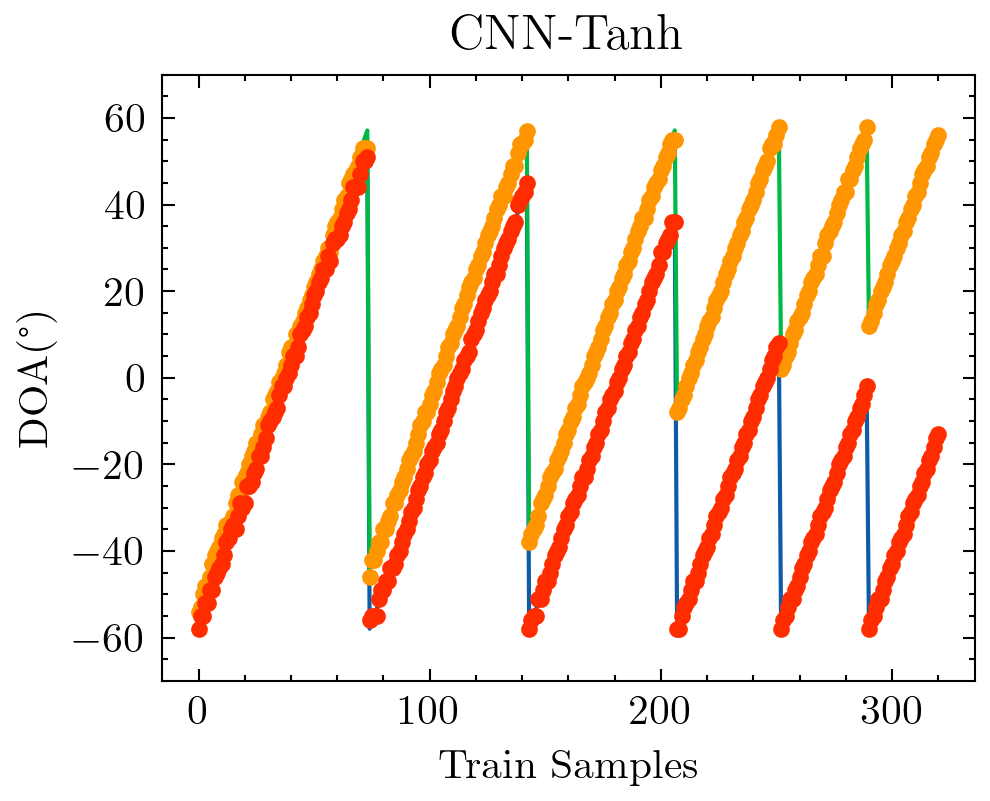

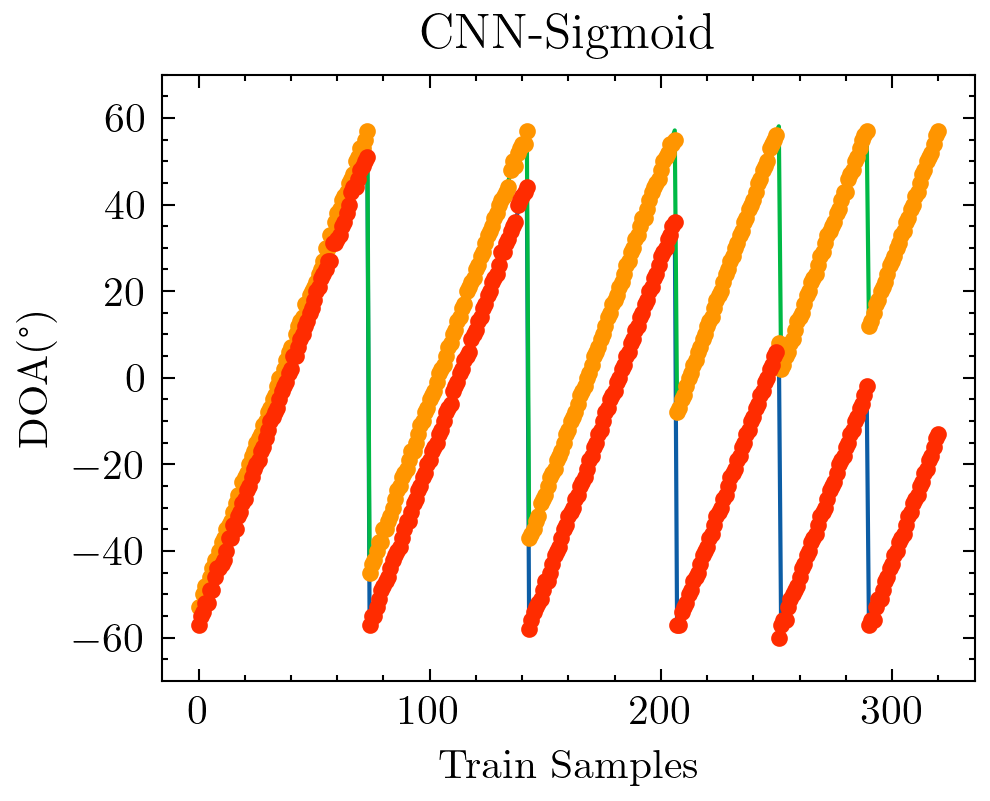

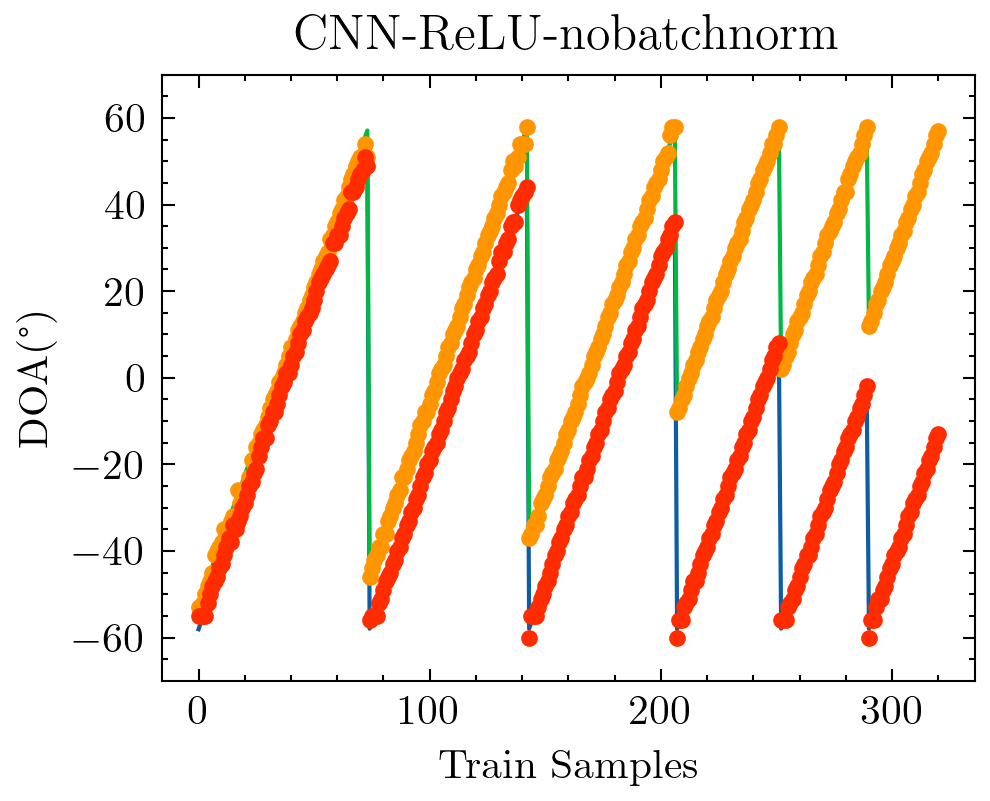

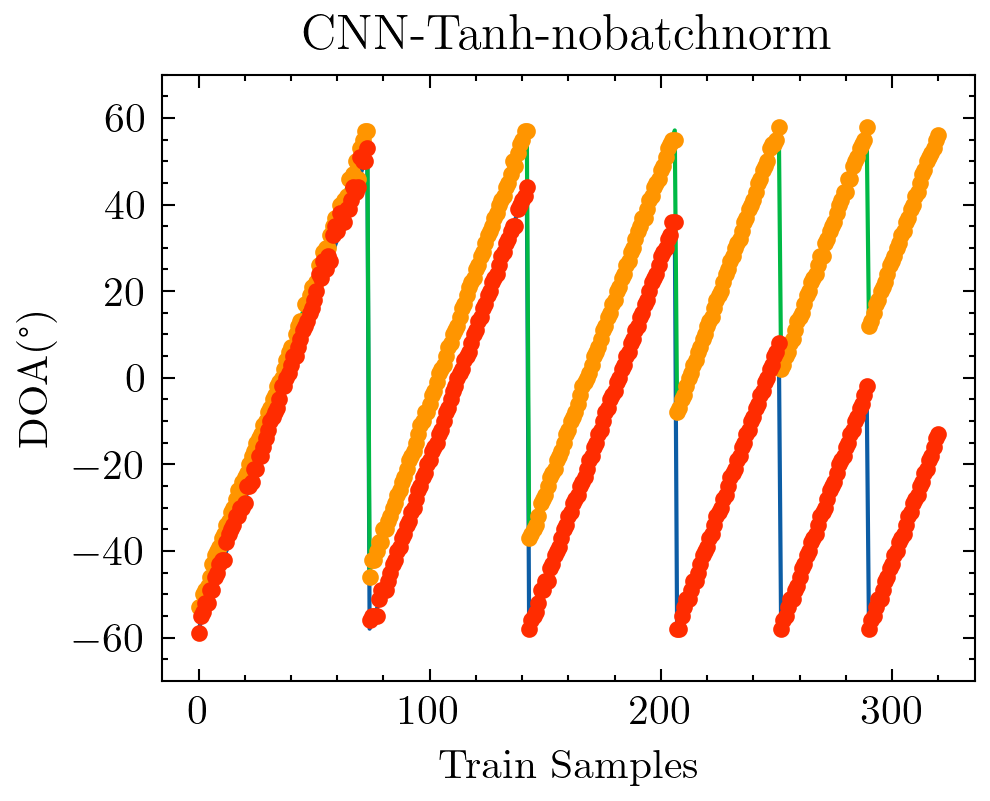

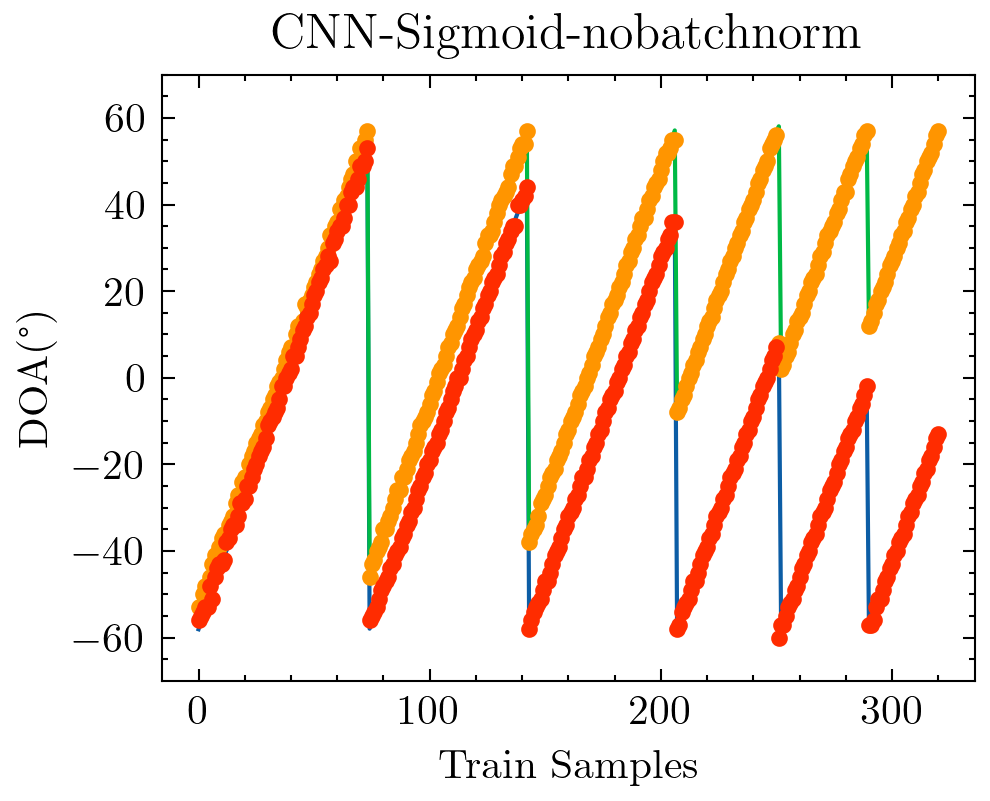

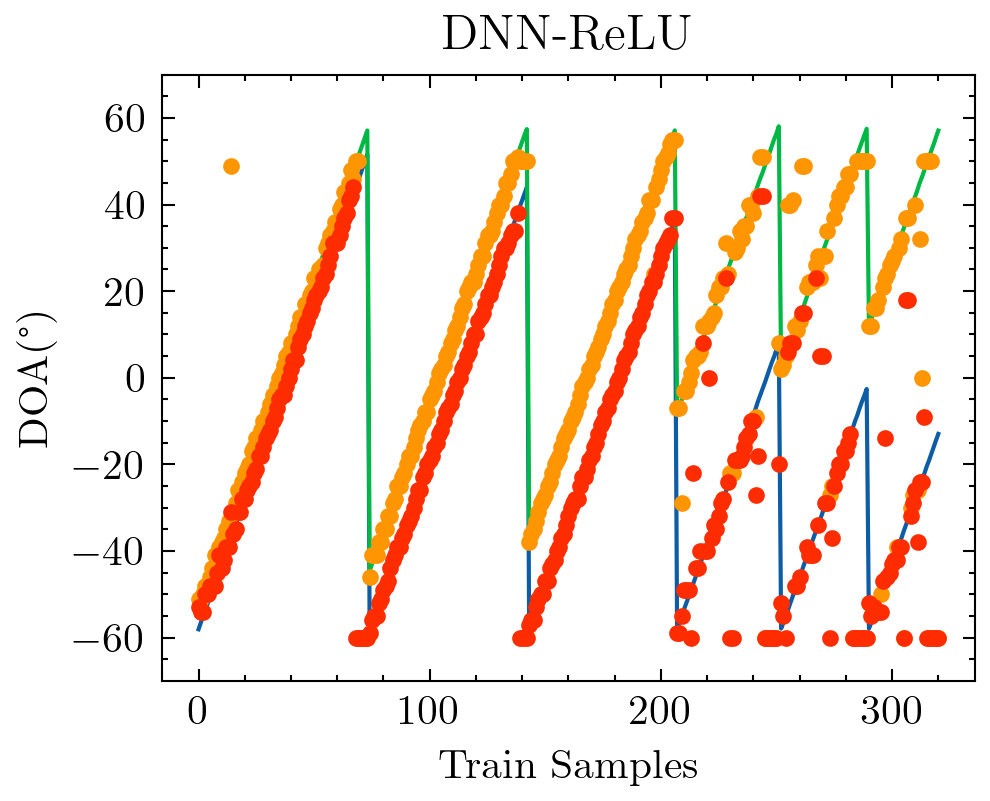

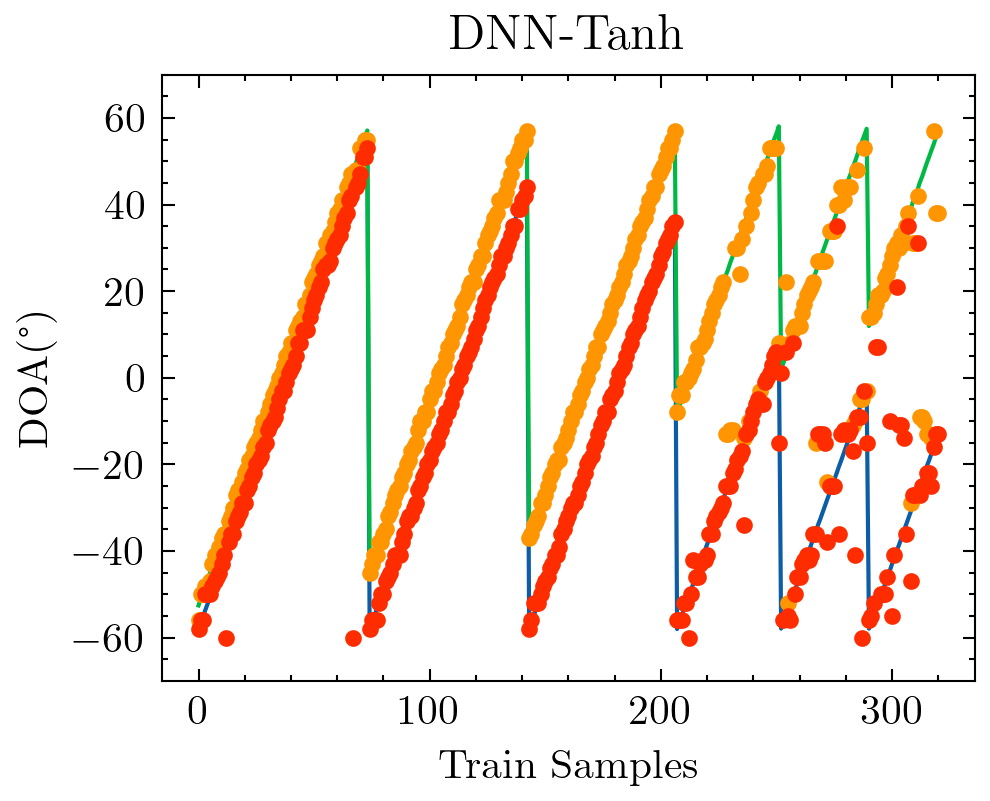

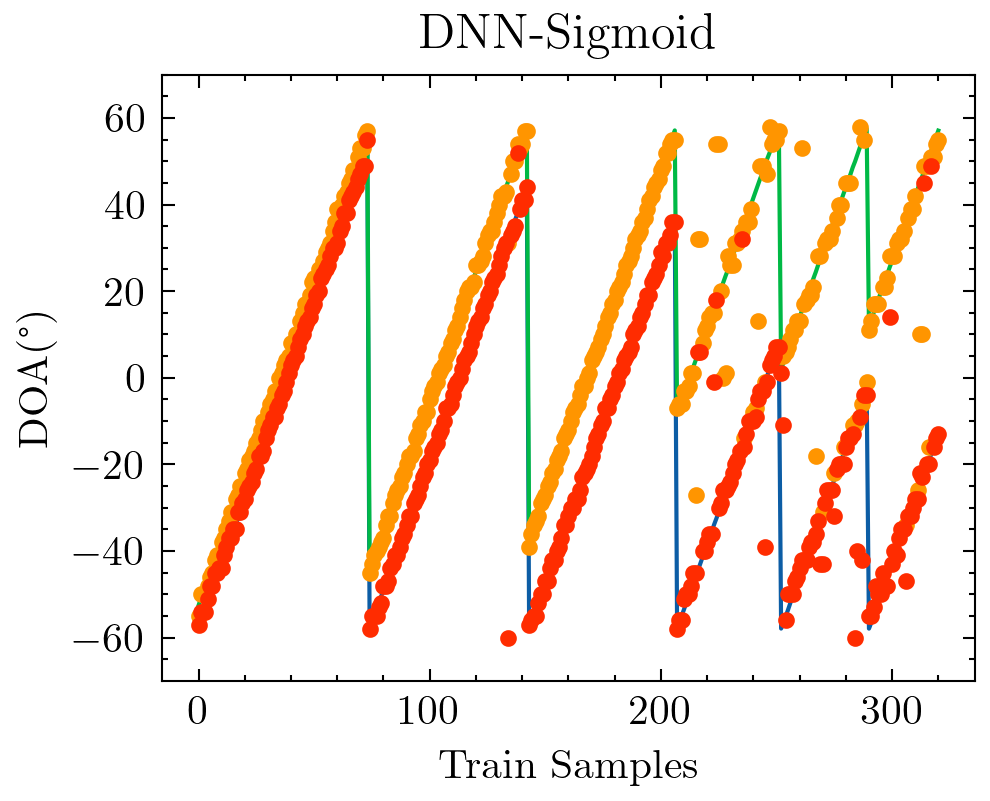

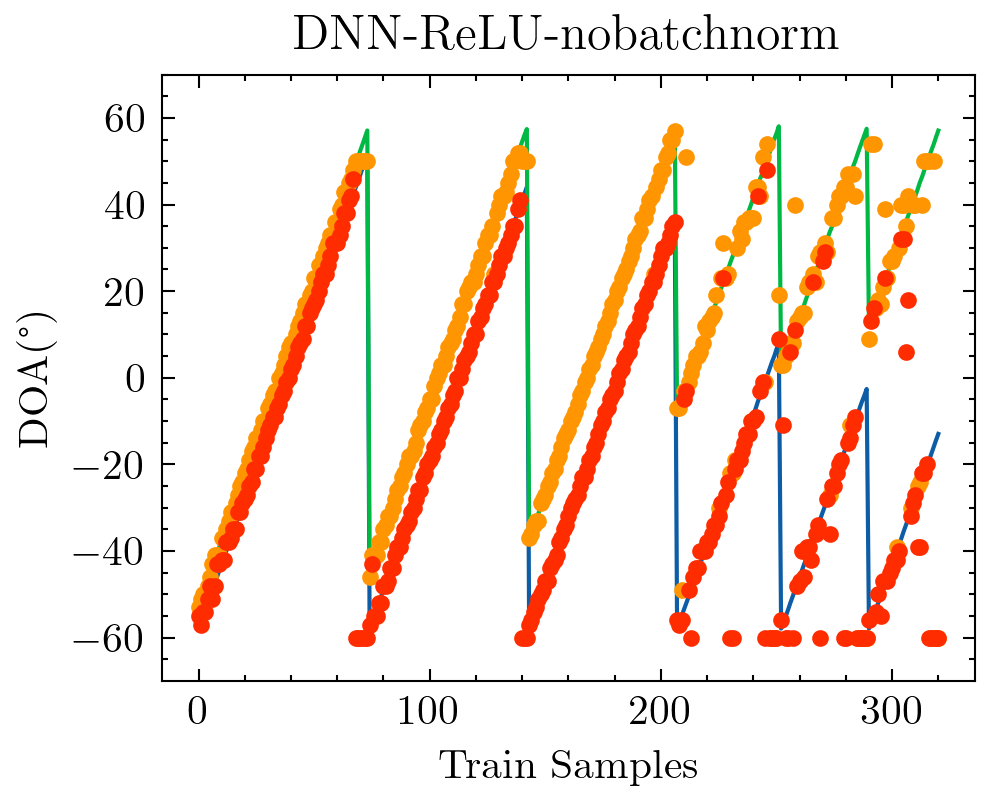

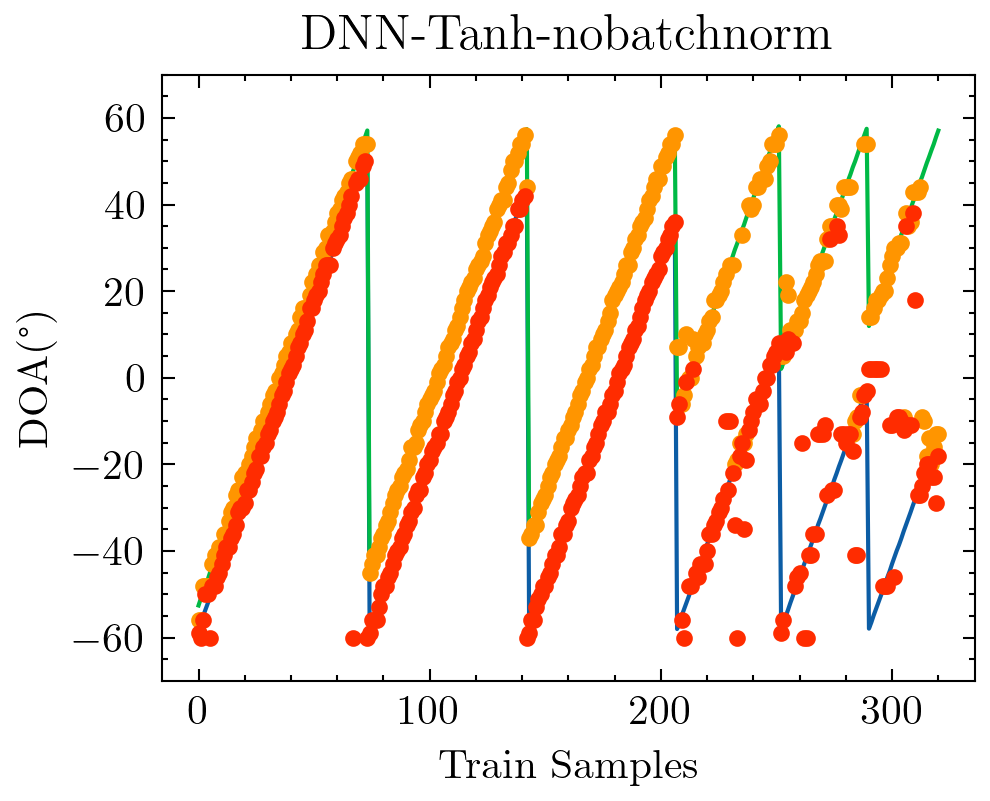

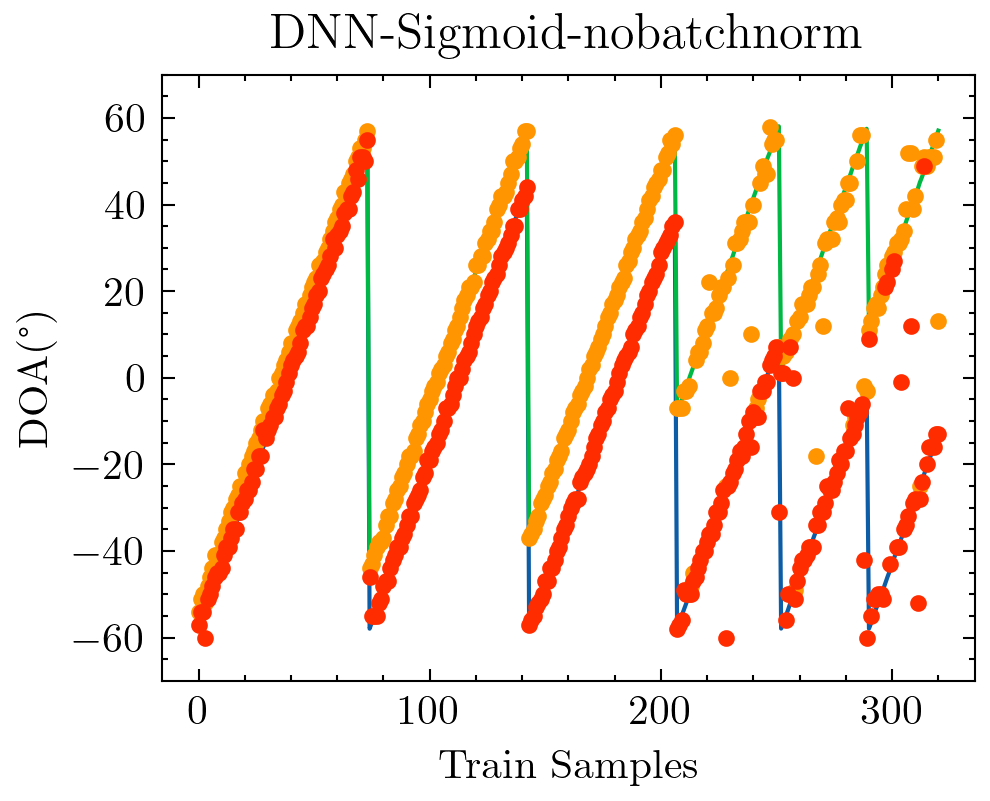

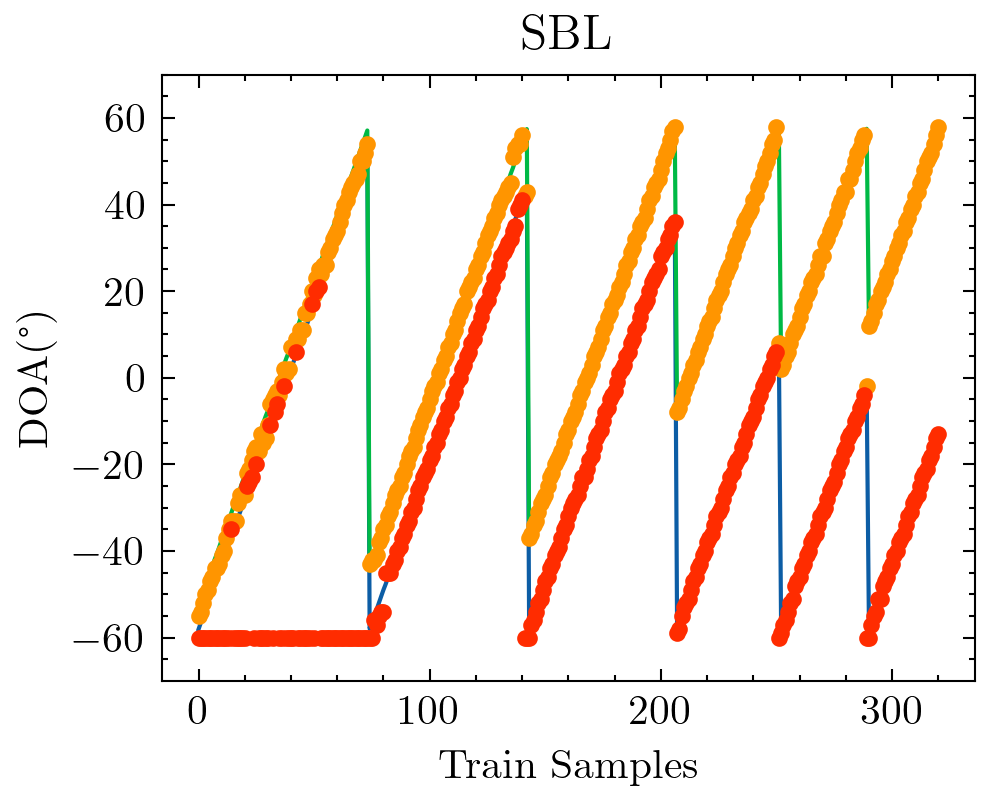

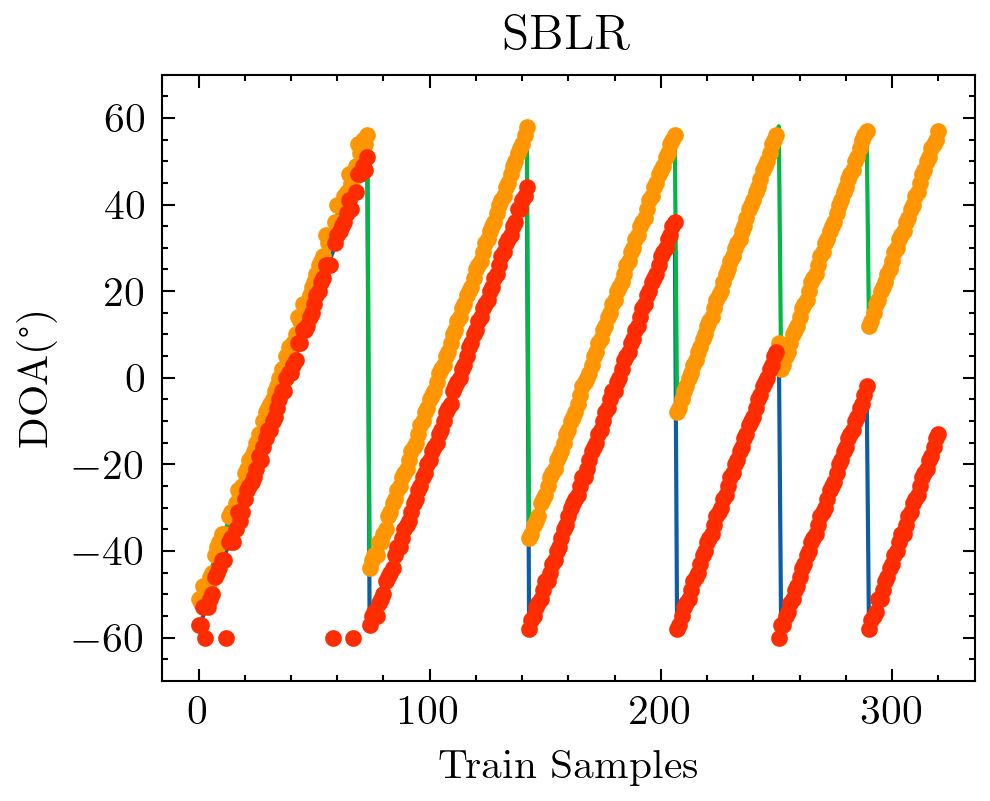

In [36]:
plotsampleindex(doa_cnnrelu, 'CNN-ReLU')
plotsampleindex(doa_cnntanh, 'CNN-Tanh')
plotsampleindex(doa_cnnsigmoid, 'CNN-Sigmoid')
plotsampleindex(doa_cnnrelu_nobatchnorm, 'CNN-ReLU-nobatchnorm')
plotsampleindex(doa_cnntanh_nobatchnorm, 'CNN-Tanh-nobatchnorm')
plotsampleindex(doa_cnnsigmoid_nobatchnorm, 'CNN-Sigmoid-nobatchnorm')
plotsampleindex(doa_dnnrelu, 'DNN-ReLU')
plotsampleindex(doa_dnntanh, 'DNN-Tanh')
plotsampleindex(doa_dnnsigmoid, 'DNN-Sigmoid')
plotsampleindex(doa_dnnrelu_nobatchnorm, 'DNN-ReLU-nobatchnorm')
plotsampleindex(doa_dnntanh_nobatchnorm, 'DNN-Tanh-nobatchnorm')
plotsampleindex(doa_dnnsigmoid_nobatchnorm, 'DNN-Sigmoid-nobatchnorm')
plotsampleindex(doa_sbl, 'SBL')
plotsampleindex(doa_sblr, 'SBLR')

# Estimation Error

In [37]:
def plot_estimate_error(predict, name):
    with plt.style.context(['science']):
        plt.rcParams['figure.dpi'] = 300
        plt.rcParams['savefig.dpi'] = 300
        plt.ylim(-10,10)
        a = np.zeros((K, r2))
        a[0,:] = predict[1,:]
        a[1,:] = predict[0,:]
        plt.plot((a - DOA_train).T,'.')
        plt.title(name)
        plt.xlabel('Train Samples')
        plt.ylabel('Estimation Error(°)')
        plt.savefig(figurepath + 'EstimateError/' + name + '.pdf')
        plt.show()

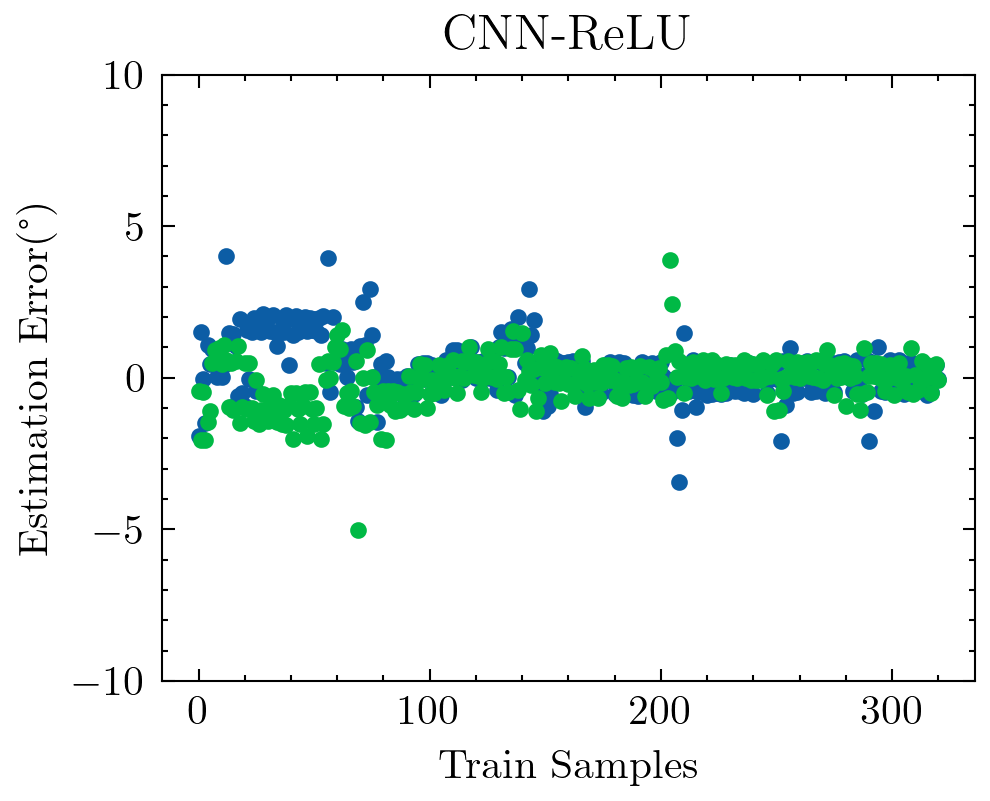

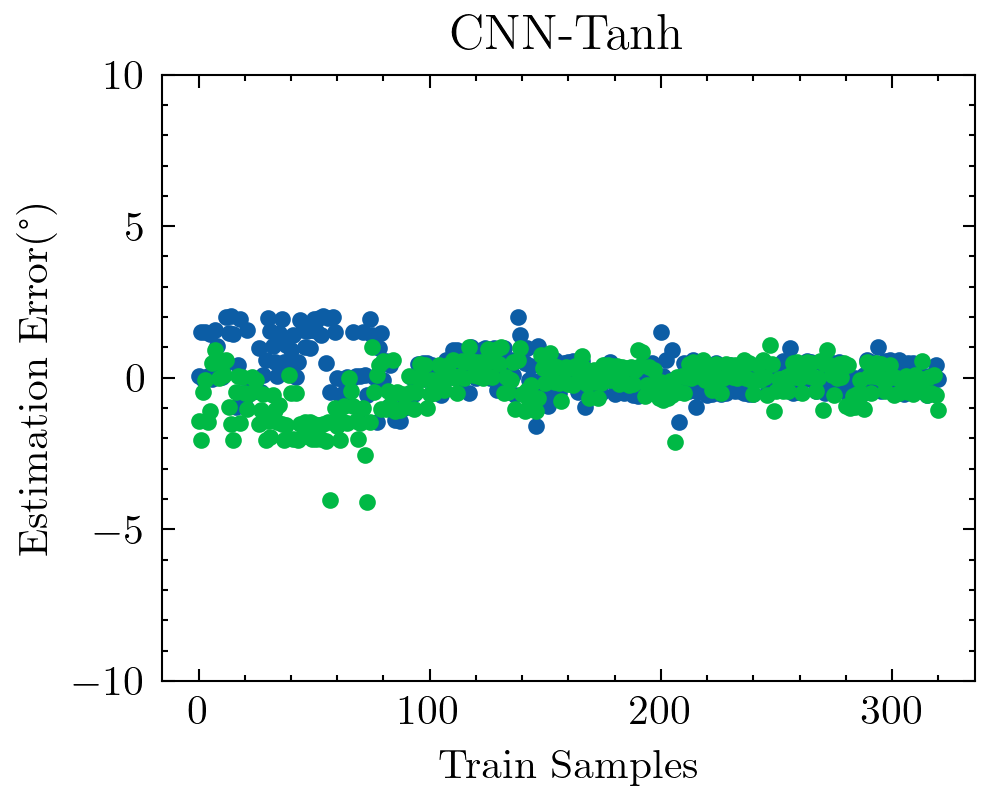

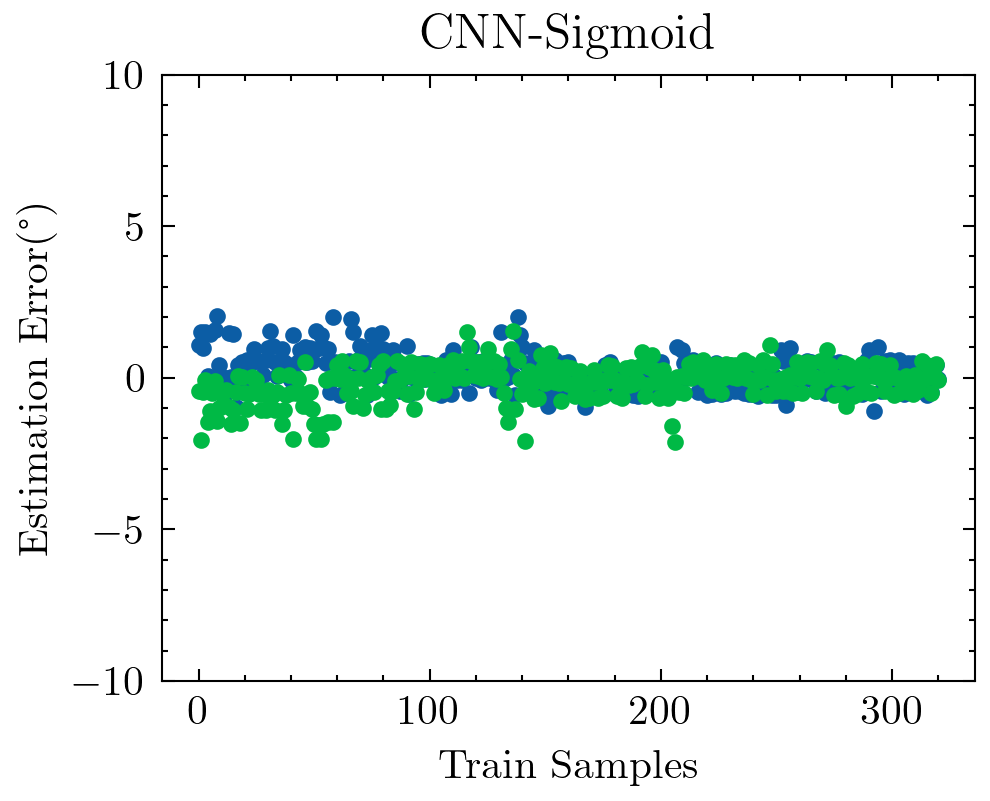

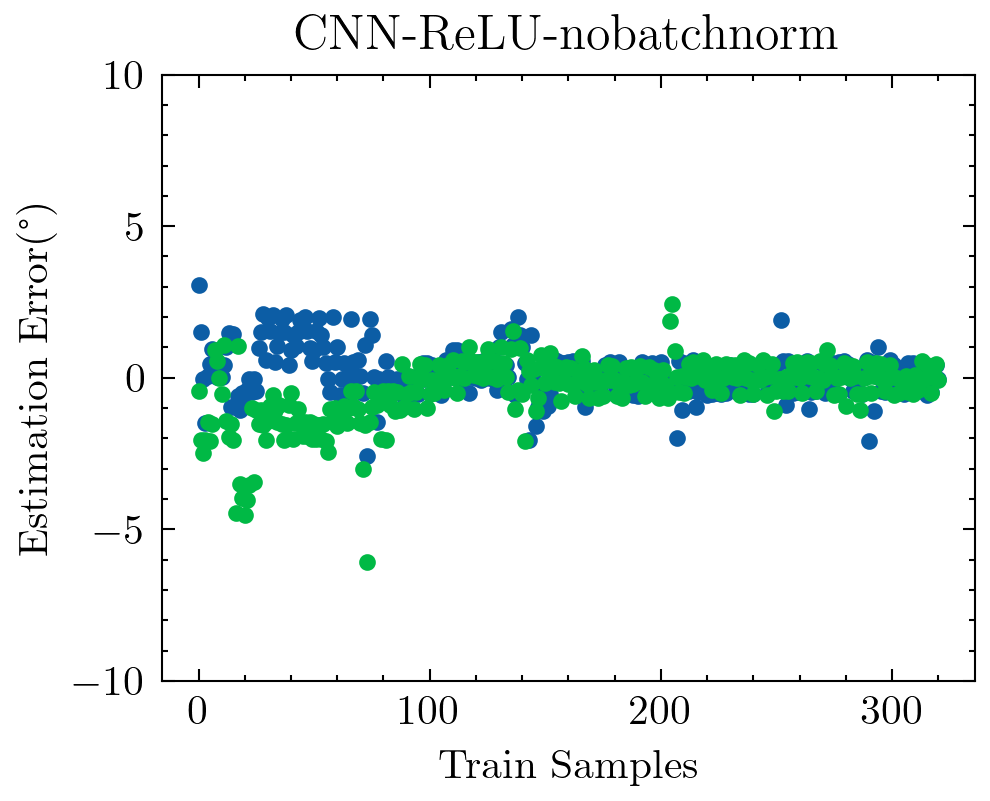

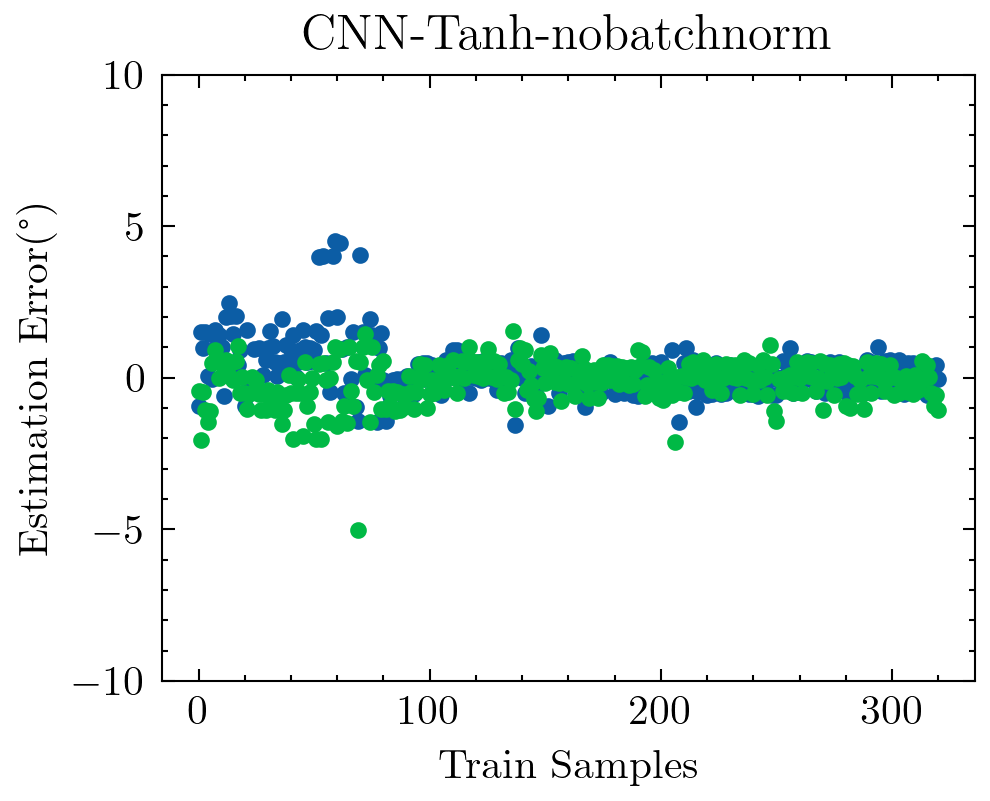

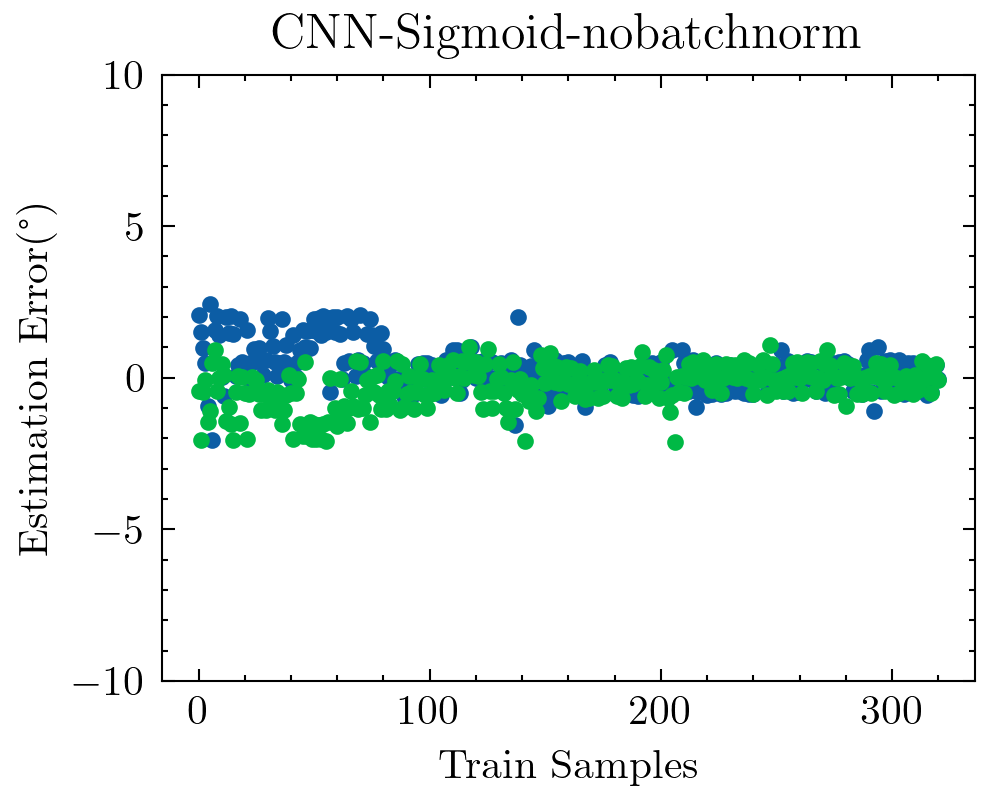

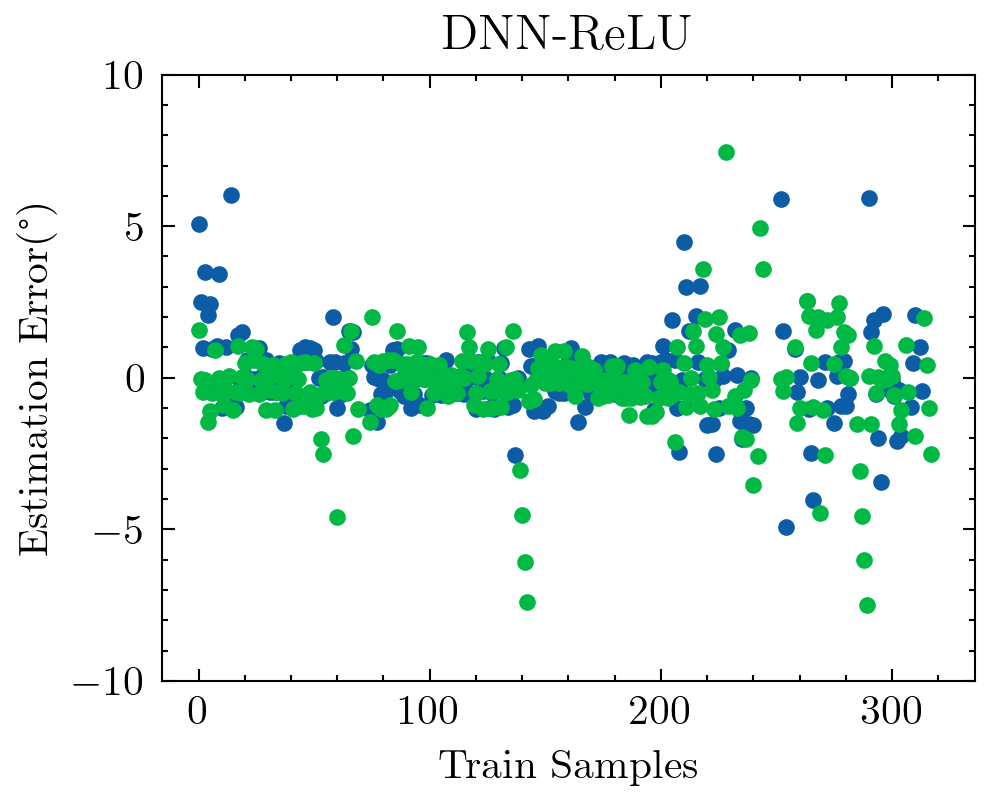

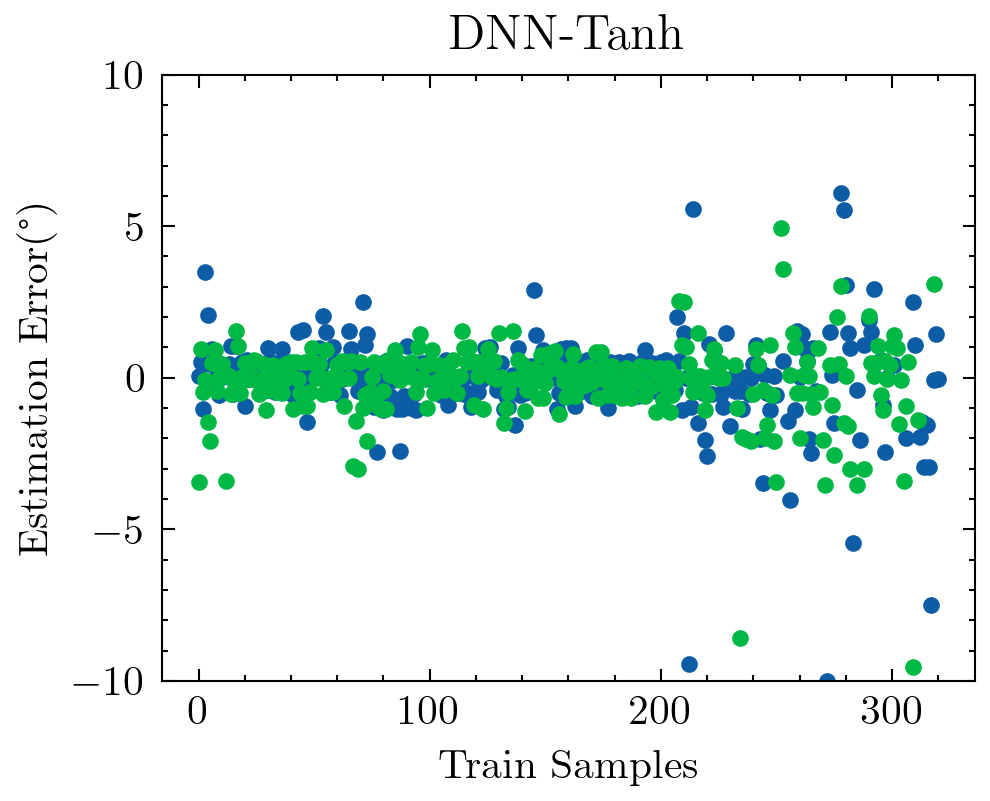

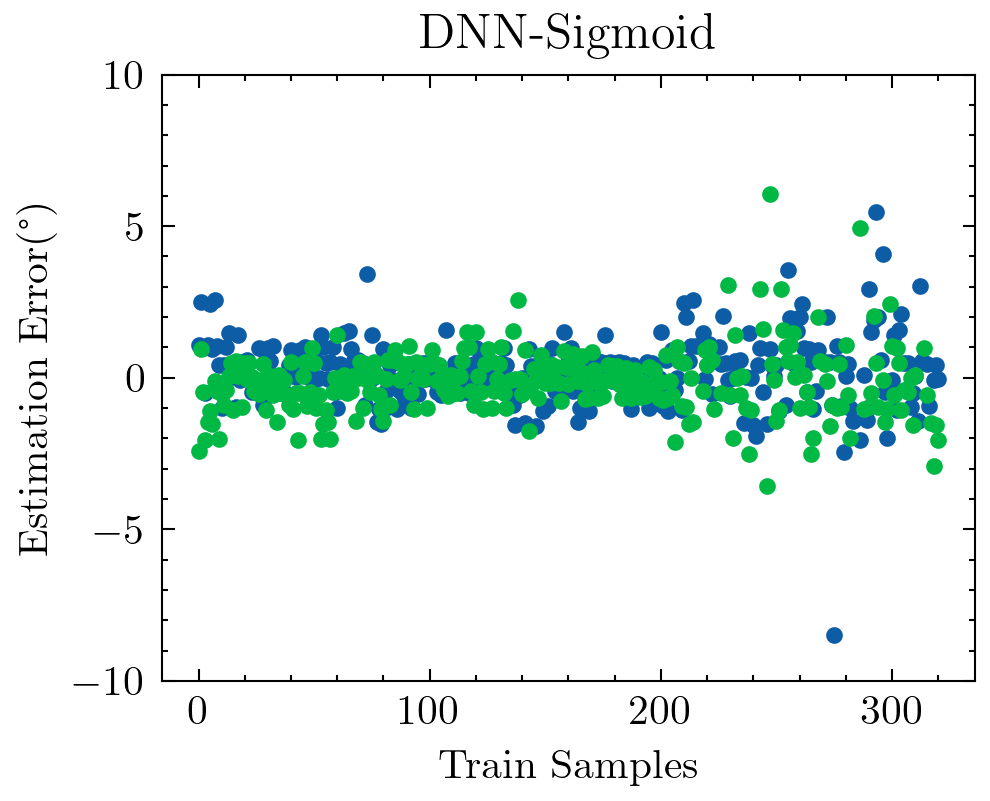

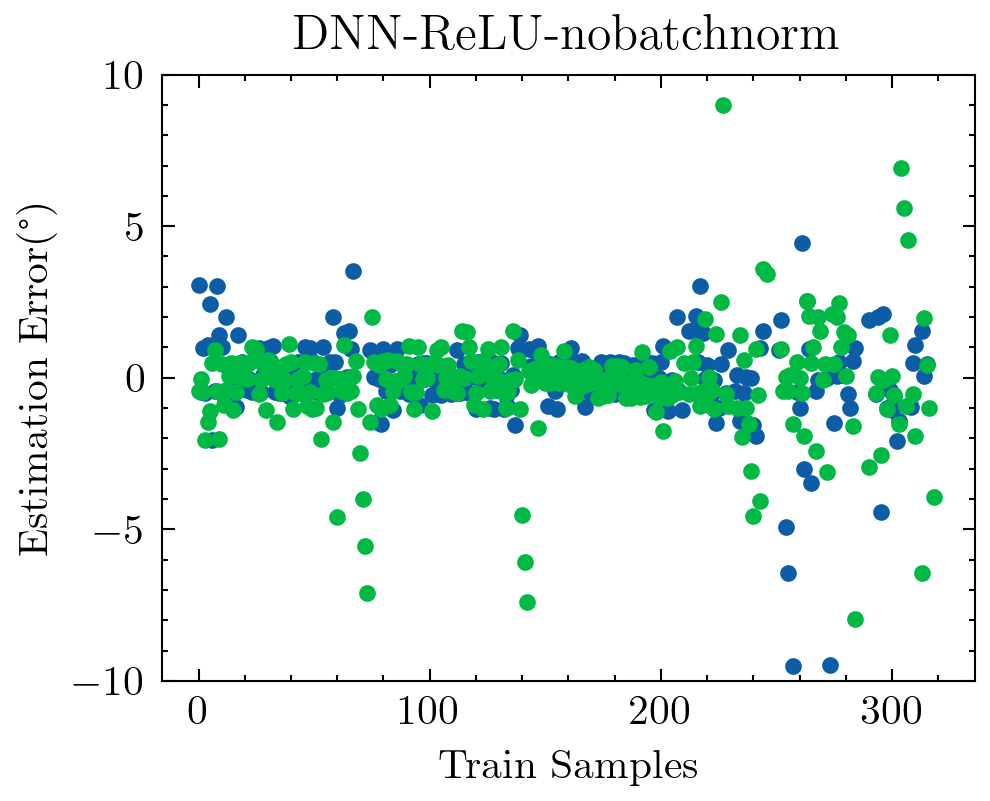

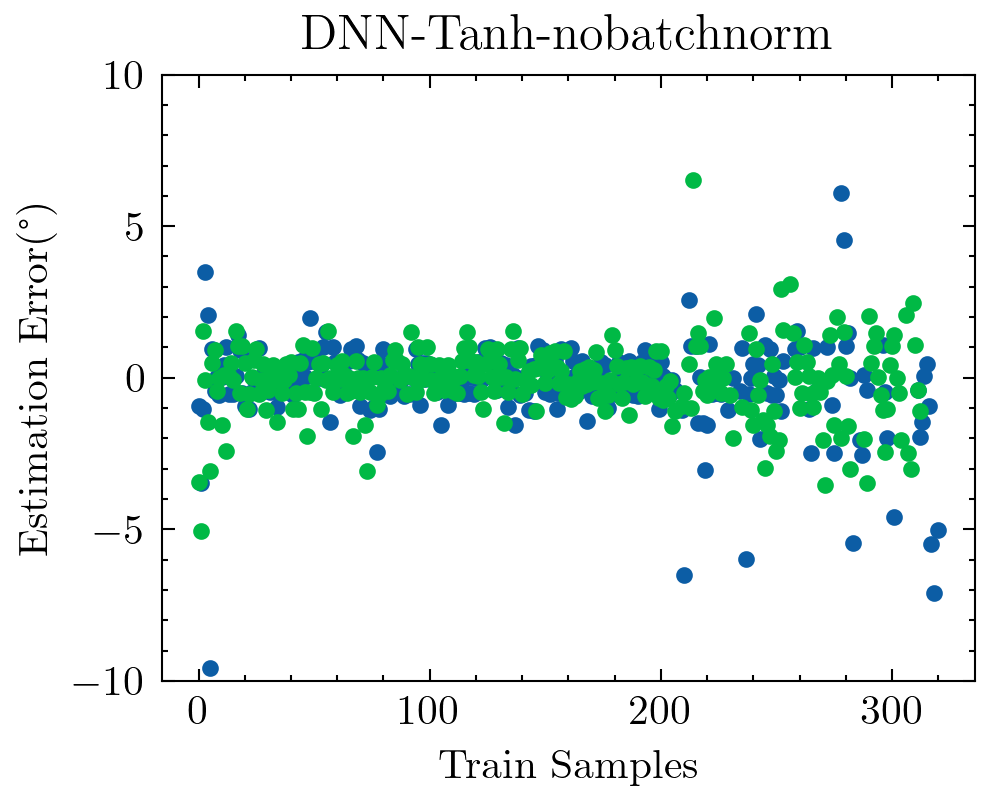

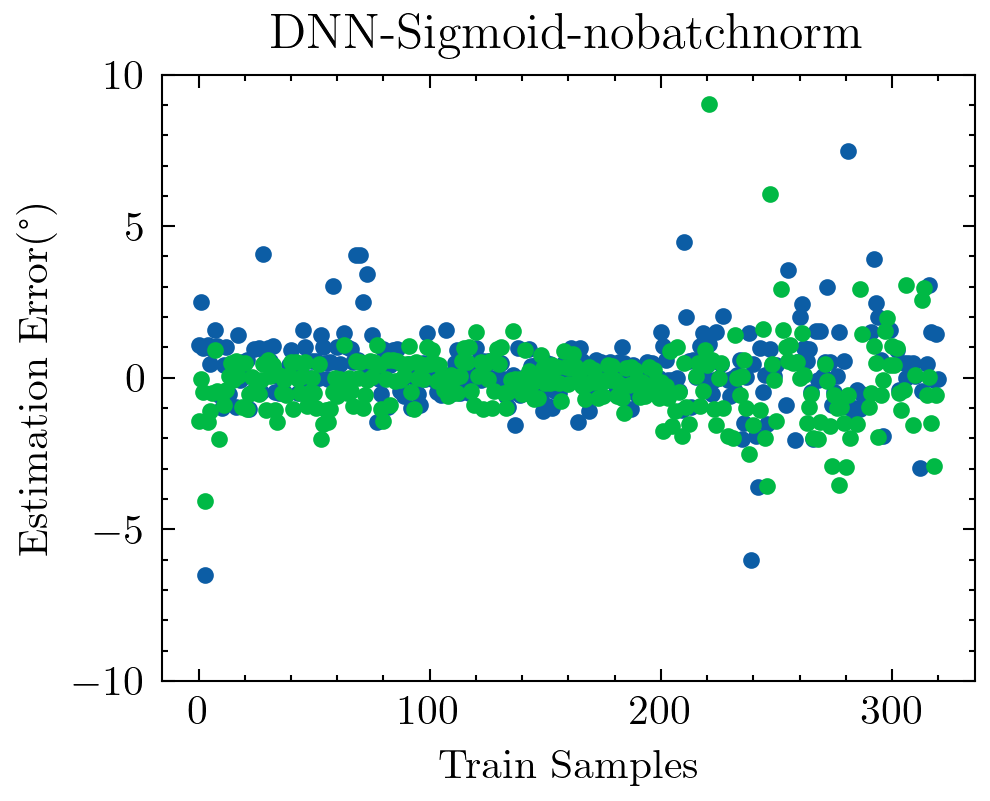

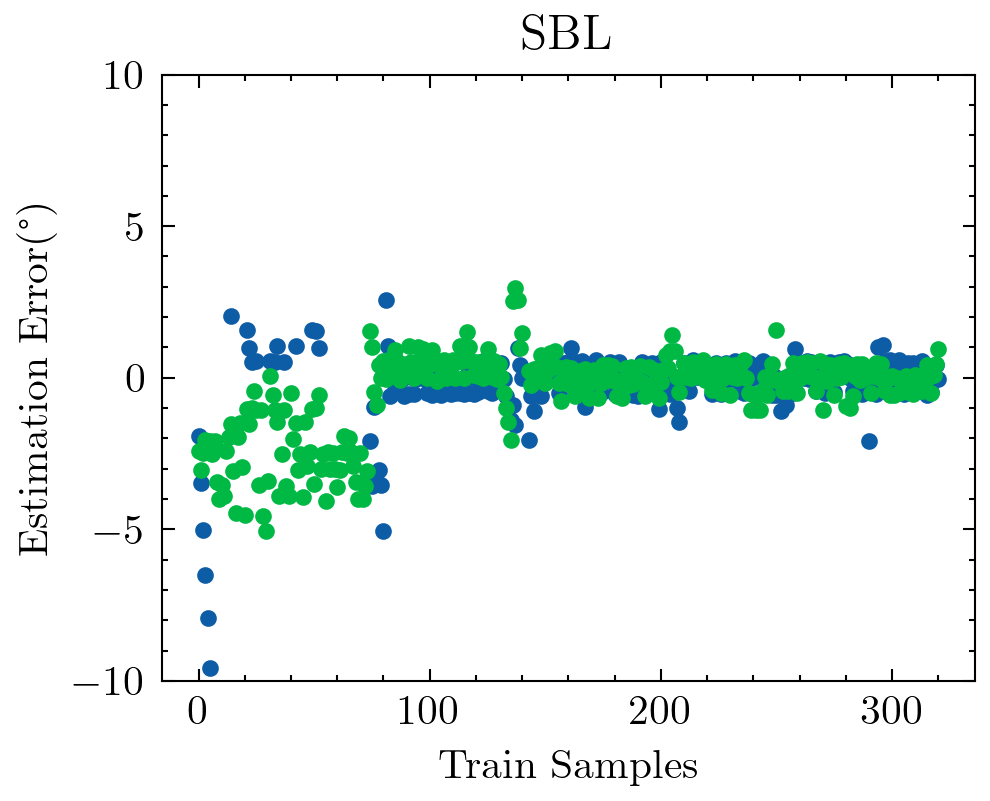

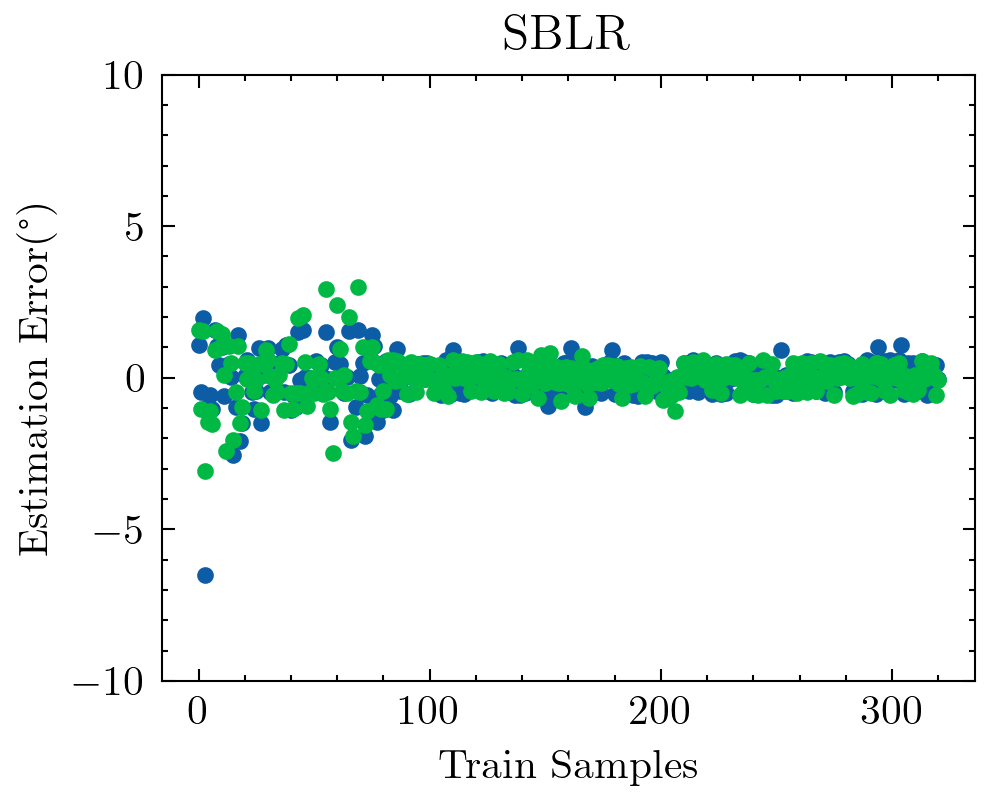

In [38]:
plot_estimate_error(doa_cnnrelu, 'CNN-ReLU')
plot_estimate_error(doa_cnntanh, 'CNN-Tanh')
plot_estimate_error(doa_cnnsigmoid, 'CNN-Sigmoid')
plot_estimate_error(doa_cnnrelu_nobatchnorm, 'CNN-ReLU-nobatchnorm')
plot_estimate_error(doa_cnntanh_nobatchnorm, 'CNN-Tanh-nobatchnorm')
plot_estimate_error(doa_cnnsigmoid_nobatchnorm, 'CNN-Sigmoid-nobatchnorm')
plot_estimate_error(doa_dnnrelu, 'DNN-ReLU')
plot_estimate_error(doa_dnntanh, 'DNN-Tanh')
plot_estimate_error(doa_dnnsigmoid, 'DNN-Sigmoid')
plot_estimate_error(doa_dnnrelu_nobatchnorm, 'DNN-ReLU-nobatchnorm')
plot_estimate_error(doa_dnntanh_nobatchnorm, 'DNN-Tanh-nobatchnorm')
plot_estimate_error(doa_dnnsigmoid_nobatchnorm, 'DNN-Sigmoid-nobatchnorm')
plot_estimate_error(doa_sbl, 'SBL')
plot_estimate_error(doa_sblr, 'SBLR')